<a href="https://colab.research.google.com/github/RayKwon2040/E_commerce-AB-test/blob/main/E_commerce_Conversion_AB_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Business Problem**

This is a women’s apparel brand launching a new e-commerce website. Based on site traffic, the goal is to design, run, and analyze an A/B experiment that tests two versions of the website.

The control group will see the current (old) website, and the treatment group will see the new website. The purpose of this test is to understand whether the new version converts customers better than the old one.

## **Table of Contents**



1.   Exploratory Data Analysis (EDA)
2.   State the hypothesis
3.   Design the experiment
4.   Run the Experiment
5.   Assess Validity Threat
6.   Conduct statistical inference
7.   Conclusion (Decide wheter to launch the new website)



## **Exploratory Data Analysis (EDA)**

In [ ]:
from datetime import datetime
import random
import math

import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from statsmodels.stats.power import TTestIndPower, tt_ind_solve_power
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.proportion import proportions_chisquare, confint_proportions_2indep

from google.colab import drive
drive.mount('/content/drive/')


# Disable warnings
from warnings import filterwarnings
filterwarnings('ignore')

# Set seed for np random
SEED = 123
np.random.seed(SEED)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
data_path = '/content/drive/MyDrive/data/'

data = pd.read_csv(data_path + 'ecommerce_conversion_ab_test_data.csv')

In [ ]:
data['TvC'].unique()

array(['C', 'V1'], dtype=object)

In [ ]:
data['date'].min()


'2021-02-01'

In [ ]:
#Set date fields as date time

data['date'] = pd.to_datetime(data['date'])

In [ ]:
#check null

data.isnull().sum()

,0
TvC,0
date,0
traffic_source,0
device_type,0
browser_language,0
login_y_n,0
region,0
return_y_n,0
conversion,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 9 columns):
 #   Column            Dtype         
---  ------            -----         
 0   TvC               object        
 1   date              datetime64[ns]
 2   traffic_source    object        
 3   device_type       object        
 4   browser_language  object        
 5   login_y_n         object        
 6   region            object        
 7   return_y_n        object        
 8   conversion        int64         
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 137.3+ MB


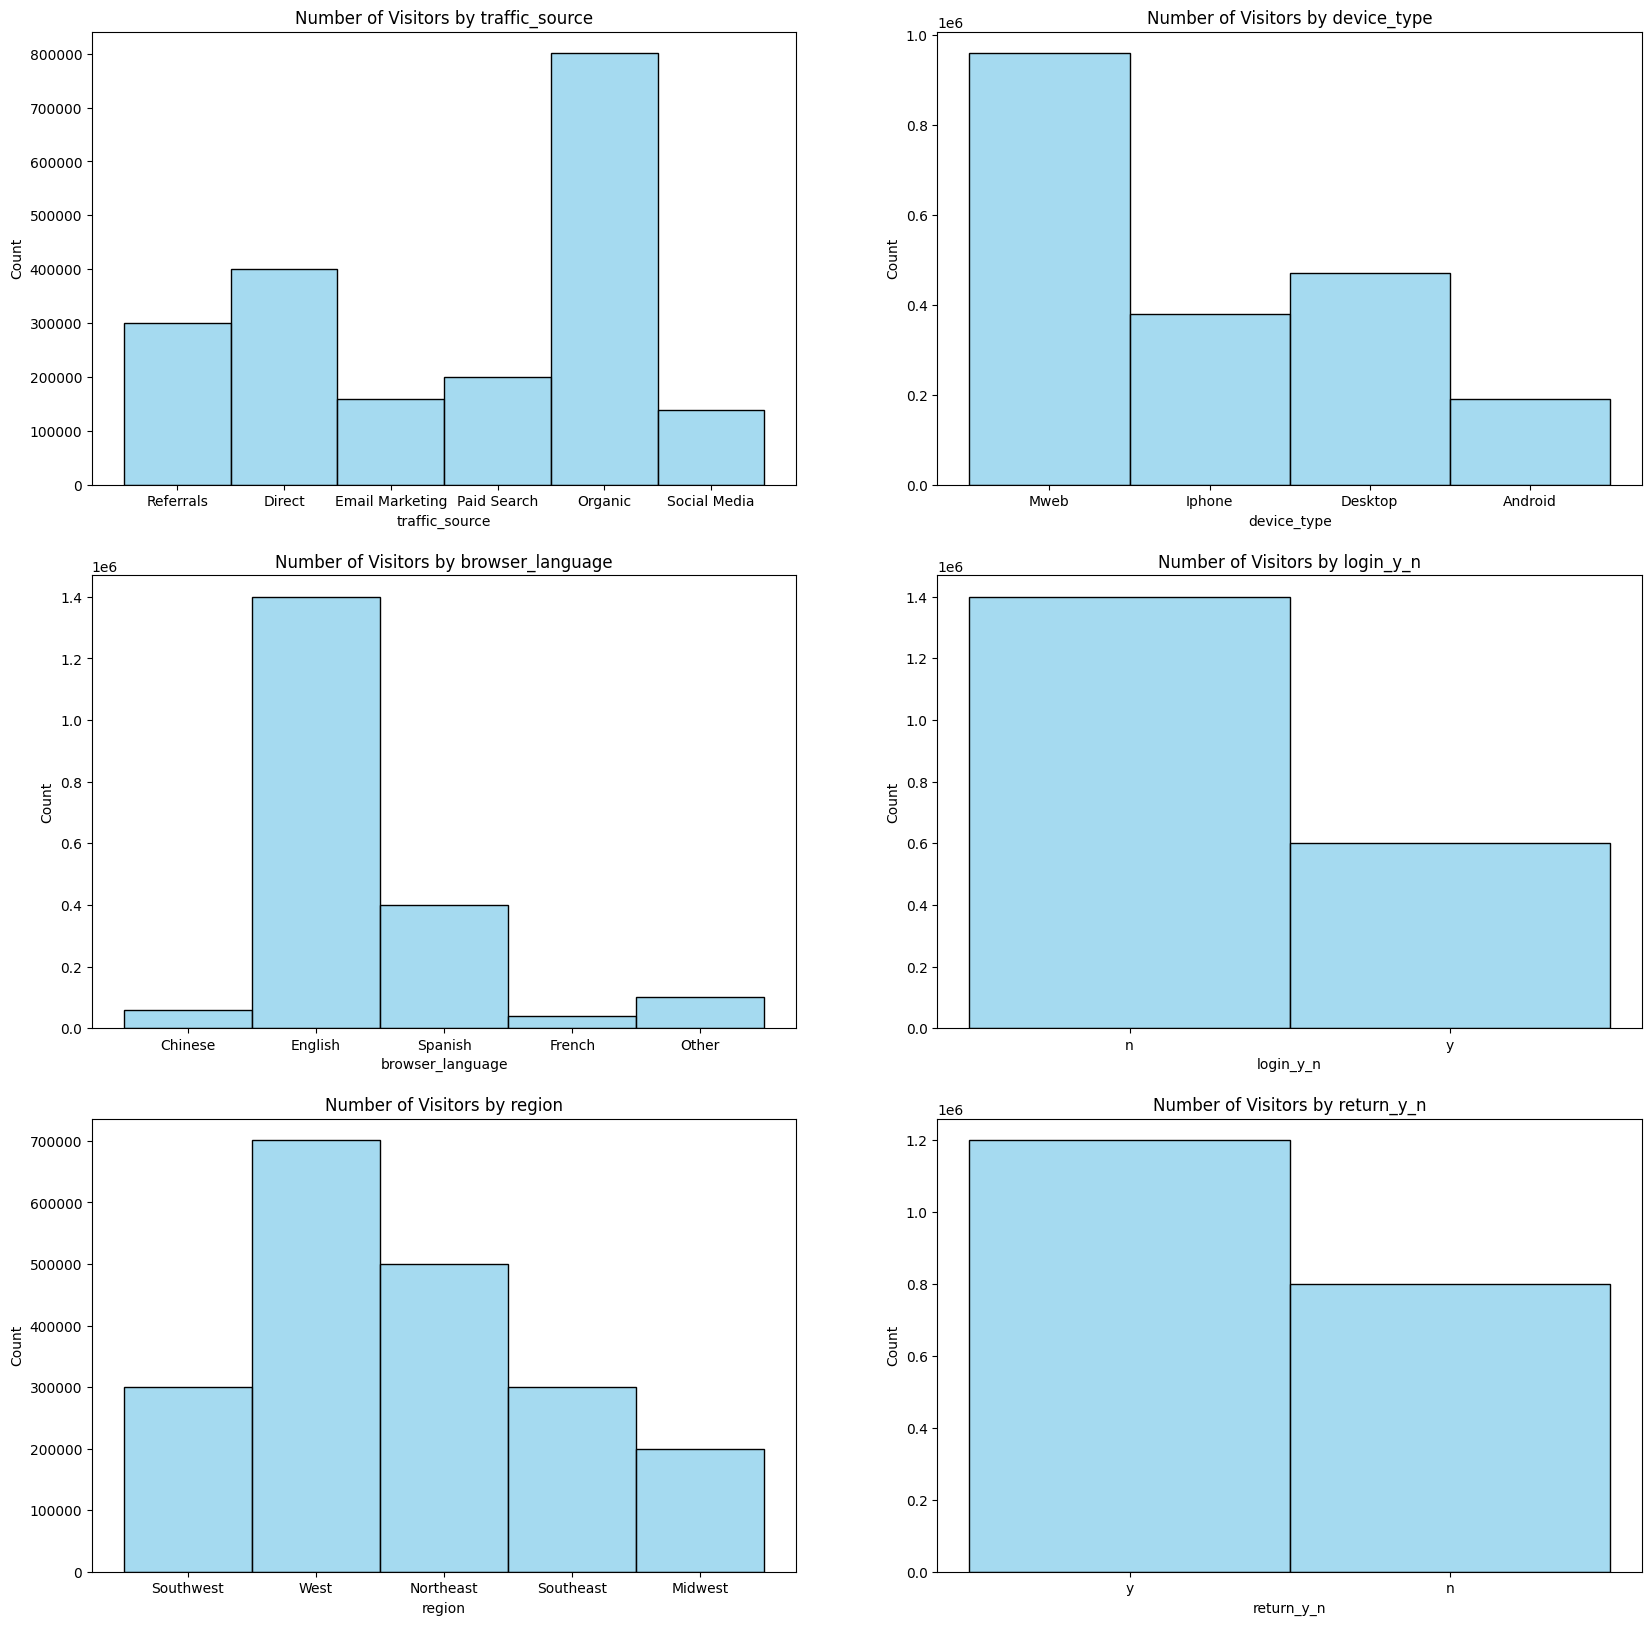

In [ ]:
#Visualize categorical variable

fig, ax = plt.subplots(3, 2, figsize=(20,20))

hist_columns = ['traffic_source','device_type','browser_language','login_y_n','region','return_y_n']

for i in range(len(hist_columns)):
  col = hist_columns[i]
  x = i // 2
  y = i % 2


  sns.histplot(data=data, x=col, ax=ax[x, y], bins='auto', color = 'skyblue')
  ax[x, y].set_title(f'Number of Visitors by {col}')



* Most visitors find the website through organic search, either by entering
keywords or clicking on non-sponsored links.

* The majority of visitors access the site via mobile web (MWeb).

* Approximately 70% of visitors browse the website without logging in.

* Most of the site traffic comes from the western region of the United States.

* Around 60% of visitors return to the website more than once.



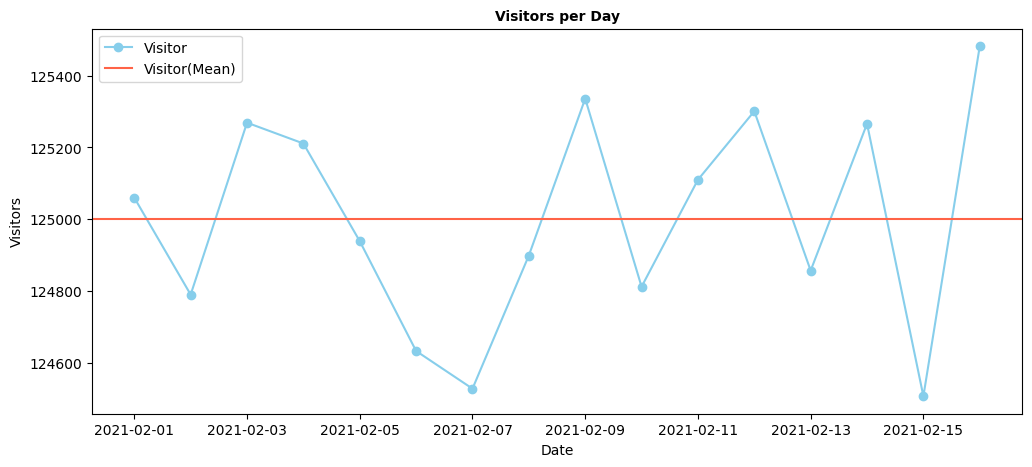

In [ ]:
#Conversion per Day

visitor_per_day = data.groupby('date')['conversion'].count()
visitor_mean = visitor_per_day.mean()

f, ax = plt.subplots(figsize=(12,5))
plt.plot(visitor_per_day.index, visitor_per_day, '-o', color = 'skyblue', label='Visitor')
plt.axhline(visitor_mean, color='tomato', linestyle='-', label='Visitor(Mean)')


plt.title('Visitors per Day', fontsize=10, weight='bold')
plt.ylabel('Visitors', fontsize=10)
plt.xlabel('Date', fontsize=10)
plt.legend()

plt.show()

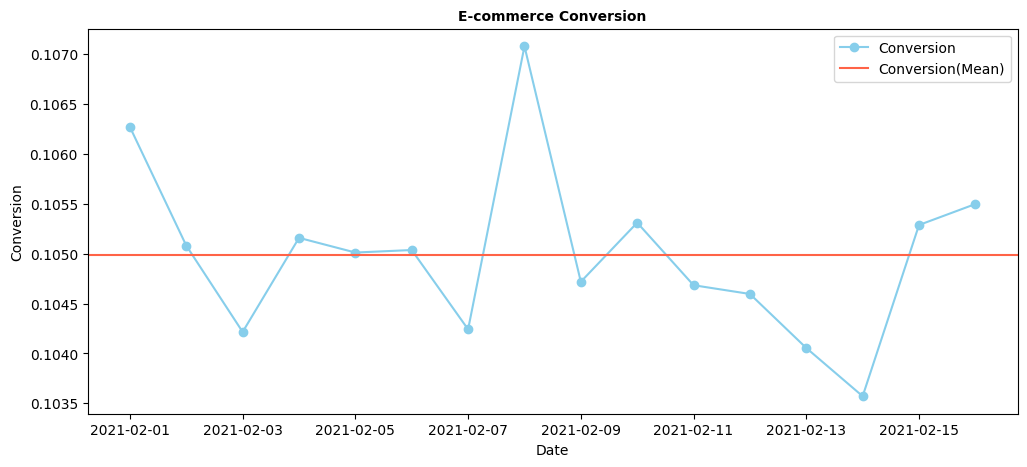

In [ ]:
#Conversion rate

conversion_per_day = data.groupby('date')['conversion'].mean()
conversion_mean = conversion_per_day.mean()

f, ax = plt.subplots(figsize=(12,5))
plt.plot(conversion_per_day.index, conversion_per_day, '-o', color = 'skyblue', label='Conversion')
plt.axhline(conversion_mean, color='tomato', linestyle='-', label='Conversion(Mean)')


plt.title('E-commerce Conversion', fontsize=10, weight='bold')
plt.ylabel('Conversion', fontsize=10)
plt.xlabel('Date', fontsize=10)
plt.legend()

plt.show()

## **State the Hypothesis**

This is followed by setting parameter values such as the significance level, statistical power and minumum dectable effect(MDE)

**Ho:** Conversion rate of old web site and new web site are the same

**Ha:** Conversion rate of old web site and new web site are different

In [ ]:
Alpha = 0.05
Power = 0.9
mde = 0.05

p1 = 0.1 #Control
p2 = p1 * (1+mde)

## **Sample Size**

To detect an effect of 5.0% lift from the pretest sign-up at 10%, the sample size per group required is 77000.
The total sample required in the experiment is 154000.


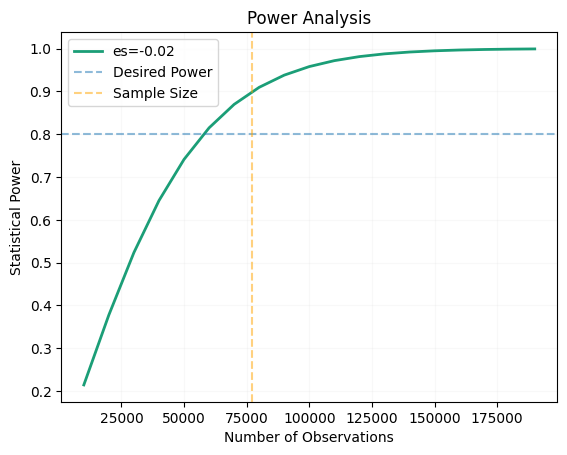

In [ ]:
cohen_D = sm.stats.proportion_effectsize(p1, p2)
cohen_D

n = tt_ind_solve_power(cohen_D, power=Power, alpha=Alpha)
n = int(round(n, -3))

print(f'To detect an effect of {100*(p2/p1-1):.1f}% lift from the pretest sign-up at {100*p1:.0f}%, '
      f'the sample size per group required is {n}.'
      f'\nThe total sample required in the experiment is {2*n}.')

ttest_power = TTestIndPower()
ttest_power.plot_power(dep_var='nobs', nobs=np.arange(10000,200000, 10000), effect_size=[cohen_D], title='Power Analysis')

# Set plot parameters
plt.axhline(0.8, linestyle='--', label='Desired Power', alpha=0.5)
plt.axvline(n, linestyle='--', color='orange', label='Sample Size', alpha=0.5)
plt.ylabel('Statistical Power')
plt.grid(alpha=0.08)
plt.legend()
plt.show()


## **Experiment Duration**


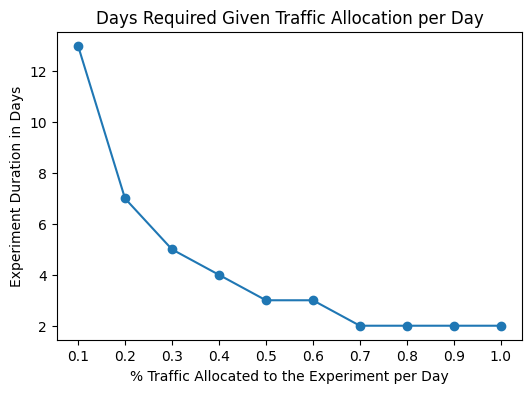

In [ ]:
alloc = np.arange(0.1, 1.1, 0.1)
size = round(visitor_mean,-3)*alloc
days = np.ceil(2*n / size)

# Generate plot
f, ax = plt.subplots(figsize=(6, 4))
ax.plot(alloc, days, '-o')
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.set_title('Days Required Given Traffic Allocation per Day')
ax.set_ylabel('Experiment Duration in Days')
ax.set_xlabel('% Traffic Allocated to the Experiment per Day')
plt.show()

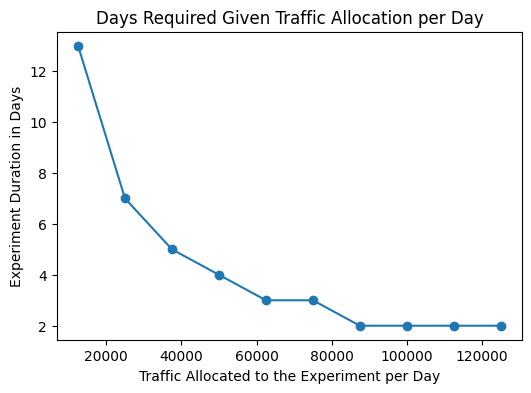

In [ ]:
f, ax = plt.subplots(figsize=(6, 4))
ax.plot(size, days, '-o')
ax.xaxis.set_major_locator(MultipleLocator(20000))
ax.set_title('Days Required Given Traffic Allocation per Day')
ax.set_ylabel('Experiment Duration in Days')
ax.set_xlabel('Traffic Allocated to the Experiment per Day')
plt.show()

In [ ]:
# Display the number of users required per day in an experiment given the experiment duration.
print(f'For a 4-day experiment, {np.ceil(n * 2 / 4)} users are required per day') # Too long to wait
print(f'For a 8-day experiment, {np.ceil(n * 2 / 8)} users are required per day') # Sweet spot between risk and time
print(f'For a 12-day experiment, {np.ceil(n * 2 / 12)} users are required per day')   # Too risky

For a 4-day experiment, 38500.0 users are required per day
For a 8-day experiment, 19250.0 users are required per day
For a 12-day experiment, 12834.0 users are required per day


## **Run the Experiment**



In [ ]:
control = data[data.TvC =='C']['conversion']
treatment = data[data.TvC =='V1']['conversion']

#Sample Size
control_size = control.count()
treatment_size = treatment.count()

#Mean
control_mean = control.mean()
treatment_mean = treatment.mean()

#Conversion Count
control_count = control.sum()
treatment_count = treatment.sum()

# Show calculation
print(f'Control Converion Rate: {control_mean}')
print(f'Treatment Conversion Rate: {treatment_mean}')

Control Converion Rate: 0.100092
Treatment Conversion Rate: 0.109884


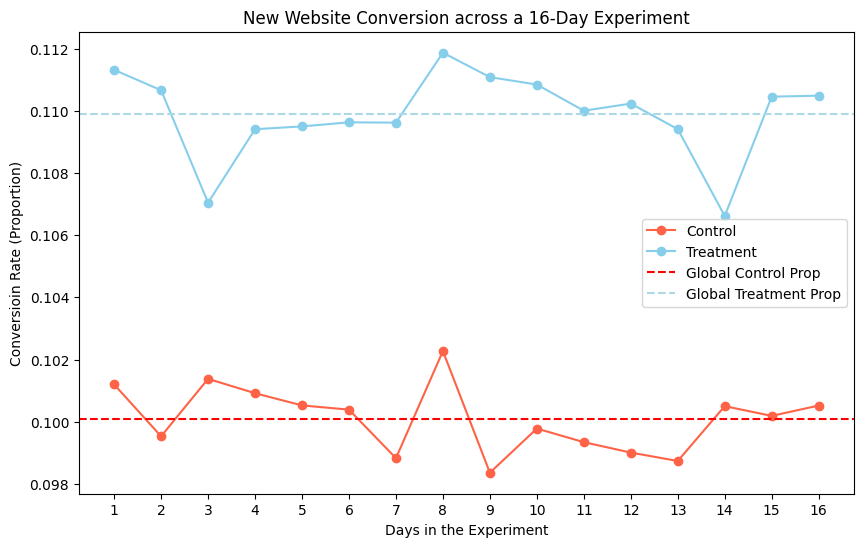

In [ ]:
conversion_per_day  = data.groupby(['TvC','date'])['conversion'].mean()
ctrl_props = conversion_per_day['C']
treat_props = conversion_per_day['V1']

exp_days = range(1, data['date'].nunique()+1)

f, ax = plt.subplots(figsize=(10,6))

ax.plot(exp_days, ctrl_props, '-o', label='Control', color = 'tomato')
ax.plot(exp_days, treat_props, '-o', label='Treatment', color = 'skyblue')
ax.axhline(control_mean, label='Global Control Prop', linestyle='--', color='r')
ax.axhline(treatment_mean, label='Global Treatment Prop', linestyle='--', color='lightblue')

# # Format plot
ax.set_xticks(exp_days)
ax.set_title('New Website Conversion across a 16-Day Experiment')
ax.set_ylabel('Conversioin Rate (Proportion)')
ax.set_xlabel('Days in the Experiment')
ax.legend()
plt.show()



*   Both groups show the highest conversion rate on Day 8 (2021-02-08, Monday), which may have been influenced by a special event.
*   The conversion rate in the treatment group drops significantly on Day 3 and Day 14.



## **Assess Validity Threats**

In [ ]:
AA_test = control.to_frame().reset_index()
AA_test['aa_group'] = np.random.choice(['A1','A2'],
                                          size=len(AA_test),
                                          p=[0.5, 0.5])

AA_control = AA_test[AA_test.aa_group == 'A1']['conversion']
AA_treatment = AA_test[AA_test.aa_group == 'A2']['conversion']

# Get stats
AA_control_cnt = AA_control.sum()
AA_treatment_cnt = AA_treatment.sum()
AA_control_rate = AA_control.mean()
AA_treatment_rate = AA_treatment.mean()
AA_control_size = AA_control.count()
AA_treatment_size = AA_treatment.count()

# Show calculation
print('-------- AA Test ----------')
print(f'A1 Conversion Rate: {AA_control_rate:.3}')
print(f'A2 Conversion Rate: {AA_treatment_rate:.3}')

-------- AA Test ----------
A1 Conversion Rate: 0.1
A2 Conversion Rate: 0.1


In [ ]:
#Run a Chi-Square test

AA_chistats, AA_pvalue, AA_tab = proportions_chisquare([AA_control_cnt, AA_treatment_cnt], nobs = [AA_control_size, AA_treatment_size])


AA_alpha = 0.05


print('Ho: There is no difference between Group A1 and Group A2.')
print('Ha: Group A1 and Group A2 are different.\n')
print(f'Significance level: {AA_alpha}')

print(f'Chi-Square = {AA_chistats:.3f} | P-value = {AA_pvalue:.3f}')

print('\nConclusion:')
if AA_pvalue < AA_alpha:
  print('Reject Ho and conclude that there is statistical significance in the difference between the two groups. Check for instrumentation errors.')
else:
  print('Fail to reject Ho. Therefore, proceed with the AB test.')

Ho: There is no difference between Group A1 and Group A2.
Ha: Group A1 and Group A2 are different.

Significance level: 0.05
Chi-Square = 0.257 | P-value = 0.613

Conclusion:
Fail to reject Ho. Therefore, proceed with the AB test.


## **Conduct Statistical Inference**

In [ ]:
AB_tstat, AB_pvalue, AB_df = ttest_ind(control, treatment)

AB_alpha = 0.05

# Grab dates
first_date = data['date'].min().date()
last_date = data['date'].max().date()

# Print results
print(f'-------- AB Test Email Sign-Ups ({first_date} - {last_date})---------\n')
print('Ho: The conversion rates between old website and new website are the same.')
print('Ha: The conversion rates between old website and new website are different.\n')
print(f'Significance level: {AB_alpha}')

print(f'T-Statistic = {AB_tstat:.3f} | P-value = {AB_pvalue:.3f}')

print('\nConclusion:')
if AB_pvalue < AB_alpha:
  print('Reject Ho and conclude that there is statistical significance in the difference of conversion between old website and new website .')
else:
  print('Fail to reject Ho.')

-------- AB Test Email Sign-Ups (2021-02-01 - 2021-02-16)---------

Ho: The conversion rates between old website and new website are the same.
Ha: The conversion rates between old website and new website are different.

Significance level: 0.05
T-Statistic = -22.591 | P-value = 0.000

Conclusion:
Reject Ho and conclude that there is statistical significance in the difference of conversion between old website and new website .


In [ ]:
# Final result w/ Confidence interval

ci = confint_proportions_2indep(treatment_count, treatment_size, control_count, control_size, method=None, compare='diff', alpha=0.05, correction=True)
lower = ci[0]
upper = ci[1]
lower_lift = ci[0]/control_mean
upper_lift = ci[1]/control_mean

In [ ]:
print('--------- Sample Sizes ----------')
print(f'Control: {control_size}')
print(f'Treatment: {treatment_size}')

print('\n--------- Conversion Counts (Rates) ----------')
print(f'Control: {control_count} ({control_mean*100:.1f}%)')
print(f'Treatment: {treatment_count} ({treatment_mean*100:.1f}%)')

print('\n--------- Differences ----------')
print(f'Absolute: {treatment_mean - control_mean:.4f}')
print(f'Relative (lift): {(treatment_mean - control_mean) / control_mean*100:.1f}%')

print('\n--------- T-Stats ----------')
print(f'Test Statistic: {AB_tstat:3f}')
print(f'P-Value: {AB_pvalue:.5f}')

print('\n--------- Confidence Intervals ----------')
print(f'Absolute Difference CI: ({lower:.3f}, {upper:.3f})')
print(f'Relative Difference (lift) CI: ({lower_lift*100:.1f}%, {upper_lift*100:.1f}%)')

--------- Sample Sizes ----------
Control: 1000000
Treatment: 1000000

--------- Conversion Counts (Rates) ----------
Control: 100092 (10.0%)
Treatment: 109884 (11.0%)

--------- Differences ----------
Absolute: 0.0098
Relative (lift): 9.8%

--------- T-Stats ----------
Test Statistic: -22.590577
P-Value: 0.00000

--------- Confidence Intervals ----------
Absolute Difference CI: (0.009, 0.011)
Relative Difference (lift) CI: (8.9%, 10.6%)


# **Conclusion**

In this E-commerce website conversion test, the objective was to increase the conversion rate by introducing a redesigned website.

A randomized controlled experiment was conducted from 2021-02-01 to 2021-02-16, assigning users to either the control group (old website) or the treatment group (new website).

The experiment showed a 9.8% lift in conversion compared to the benchmark (old website), exceeding the 10% improvement target. **The result was statistically significant**, with a 95% confidence interval ranging from 9% to 11%.

Given the strong practical and statistical significance of the improvement, our recommendation is to proceed with the launch of the new website.